# Actors Marriage and Divorce according to Wikipedia

Building on the output from the notebook "Extracting and Parsing Actors Marriage & Divorce Info" (https://github.com/EvangelineFan/wiki_marriage_divorce/blob/master/Extracting%20and%20Parsing%20Actors%20Info%20from%20Wikipedia.ipynb), I have further cleaned and analysed the data, and have come across some interesting obervations.

In [ ]:
! pip install ndjson

In [1]:
from pandas.io.json import json_normalize
import pandas as pd
import ndjson
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

#### Load data and flatten nested column

In [2]:
path = os.getcwd() + '\\wiki\\cleaned_actors.ndjson'
with open(path) as file:
    data = ndjson.load(file)
data = [dict(zip(['name','birth_day','spouse','label','gender','nationality','awards'],x)) for x in data]
all_actors=json_normalize(data)
all_actors['occupation']='actors'
all_actors['awards_count'] = all_actors.awards.str.len()
all_actors=all_actors[['name','birth_day','birth_day.year','birth_day.month','birth_day.date','spouse','label','gender','nationality','awards','awards_count']]
all_actors.head()

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,spouse,label,gender,nationality,awards,awards_count
0,Amitabh Bachchan,NaN,1942,10,11,"[{'spouse': 'Jaya Bachchan|Jaya Bhaduri', 'fro...",nested,male,[Indian],[Category:Best Actor National Film Award winne...,2
1,Aaliyah,NaN,1979,1,16,"[{'spouse': 'R. Kelly', 'from': 'August 31, 19...",nested,female,[American],[],0
2,Anthony Hopkins,NaN,1937,12,31,"[{'spouse': 'Petronella Barker (actress, born ...",nested,male,[Welsh],"[Category:Best Actor BAFTA Award winners, Cate...",8
3,Ardal O'Hanlon,NaN,1965,10,8,[Melanie O'Hanlon],not_nested,male,[],[],0
4,Adam Carolla,NaN,1964,5,27,"[Lynette Paradise (2002–present), 2002–present]",not_nested,male,[American],[],0


#### Add spouse count for actors with nested spouse info

In [3]:
nested=all_actors[all_actors['label']=='nested'][['name', 'birth_day', 'birth_day.year', 'birth_day.month',
       'birth_day.date', 'label', 'gender',
       'nationality', 'awards', 'awards_count', 'spouse']]
nested['spouse_count'] = nested.spouse.str.len()

#### Clean records with unnested spouse info

In [4]:
unnested = all_actors[all_actors['label']=='not_nested']
def clean_this_mess(list):
    if len(list)==0:
        return []
    elif len(list)==2:
        return [list[0].strip('< br / >').strip('< br/ >').strip('< br >')]
    else:
        return list[0].split(' < br')
unnested=pd.concat([unnested.drop(['spouse'], axis=1), unnested['spouse'].apply(lambda x: clean_this_mess(x))], axis=1)
unnested['spouse_count'] = unnested.spouse.str.len()

### How many times do actors get married?

In [5]:
combined_actors = nested.append(unnested)
from termcolor import colored
from dateutil.parser import parse
def parse_year(x):
    try:
        return parse(x,fuzzy=True).year
    except:
        return None
combined_actors['age'] = combined_actors['birth_day.year'].apply(lambda x: 2019-parse_year(x) if parse_year(x) is not None else 999)
adult_actors = combined_actors[combined_actors['age']>=18]
never_married = adult_actors[adult_actors['spouse_count']==0].name.count()
actor_count = combined_actors.name.count()
adult_count = adult_actors.name.count()
total_marriages = adult_actors.spouse_count.sum()
median_spouse_count = combined_actors.spouse_count.median()
print('%d actors\' information was collected from the "21-century Actors/Actresses" categories on Wikipedia. Assuming those with age unknown are 18 or above, '
      'that is %d adult actors, among whom %d (or %d%%) have never been married, while the rest have got married a total of %d times. We read a lot about Hollywood weddings in taloids, '
      'but the median number of times adult actors get married turns out to be - %d!' %(actor_count, adult_count, never_married, never_married/adult_count *100, total_marriages, median_spouse_count))

23953 actors' information was collected from the "21-century Actors/Actresses" categories on Wikipedia. Assuming those with age unknown are 18 or above, that is 23780 adult actors, among whom 14881 (or 62%) have never been married, while the rest have got married a total of 11147 times. We read a lot about Hollywood weddings in taloids, but the median number of times adult actors get married turns out to be - 0!


### Do more successful actors tend to marry more times?

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


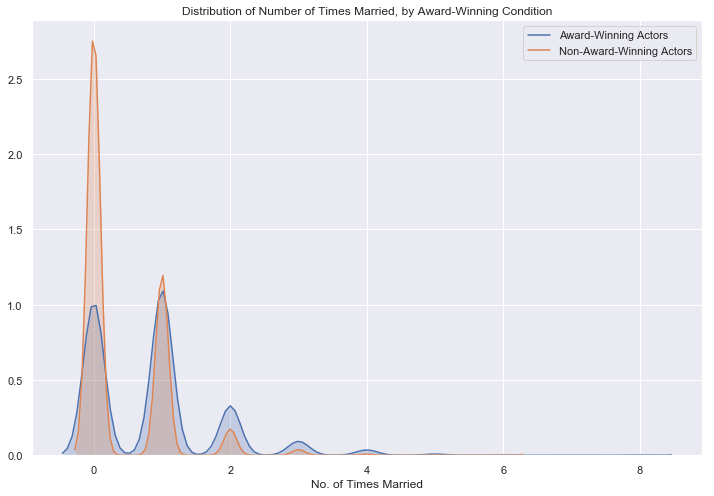

In [6]:
plt.figure(figsize=(12,8))
sns.kdeplot(data=adult_actors[adult_actors['awards_count'] > 0]['spouse_count'],label='Award-Winning Actors', shade=True)
sns.kdeplot(data=adult_actors[adult_actors['awards_count'] == 0]['spouse_count'],label='Non-Award-Winning Actors', shade=True)

plt.xlabel('No. of Times Married')
plt.title('Distribution of Number of Times Married, by Award-Winning Condition') #How many roads must a man/woman walk down
plt.legend()

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Text(0.5, 1.0, 'More Successful, More Marriages?')

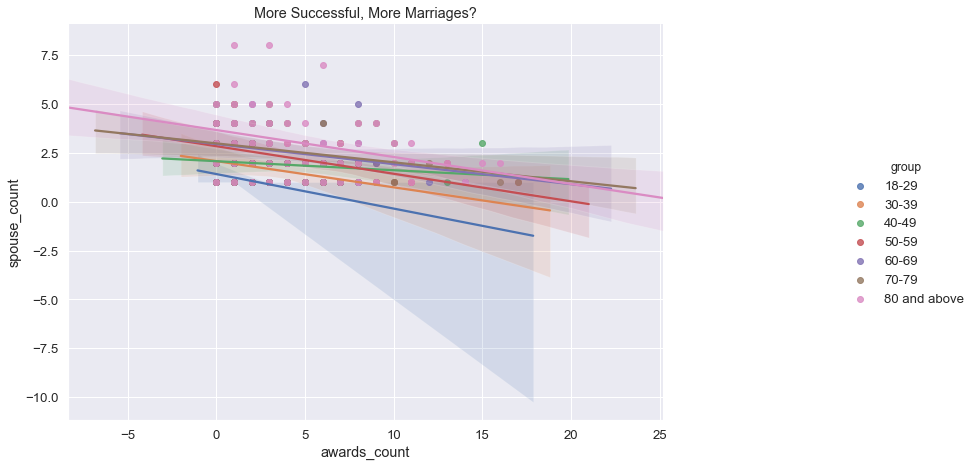

In [7]:
actors_w_age = adult_actors[adult_actors['age'] != 999]
actors_w_age['group']=pd.cut(actors_w_age['age'], bins=[18, 30, 40, 50, 60, 70, 80,200], include_lowest=True, right=False, labels=['18-29', '30-39', '40-49','50-59','60-69','70-79','80 and above'])
marriage_vs_spouse=pd.DataFrame({'count' : actors_w_age.groupby( [ 'group', 'awards_count','spouse_count']).size()}).reset_index()
marriage_vs_spouse=marriage_vs_spouse[marriage_vs_spouse['spouse_count'] >0]
sns.set(font_scale=1.2)
sns.lmplot(x='awards_count', y='spouse_count', data=marriage_vs_spouse, fit_reg=True, hue='group')#,scatter_kws={"s": actors_w_age.name.count()/100}
plt.gcf().set_size_inches(16, 7)
plt.title("More Successful, More Marriages?")

We often read about celebrities blaming the failure of their marriages on one of the partners rising to fame. It is true that there is a higher chance for award-winning actors and actresses to marry twice or more compared to their less recognised counterparts. But this tendency does not increase with more awards won. In fact, after eliminating actors who have never been married, the more awards actors win, the fewer times they tend to marry - and this is consistent across generations.

### Actors Married The Most Times

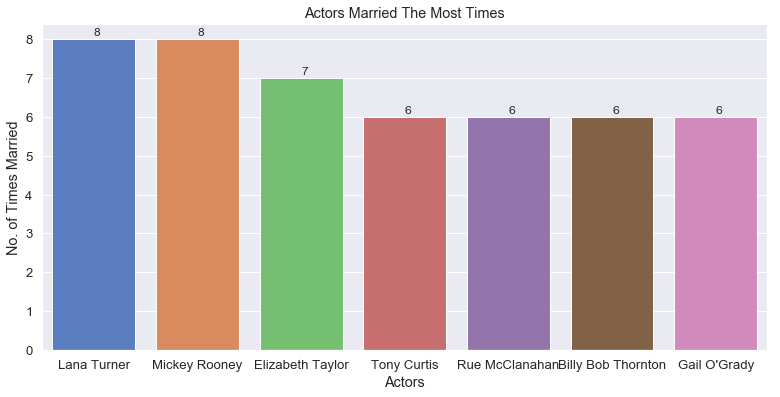

In [8]:
sorted_by_spouse_count = combined_actors.sort_values(by=['spouse_count'],ascending=False)
actors_married_most = sorted_by_spouse_count[sorted_by_spouse_count['spouse_count']>5]
plt.figure(figsize=(13,6))
sns.set(font_scale=1.2)
sns.barplot(x=actors_married_most['name'], y=actors_married_most['spouse_count'],palette='muted')#Blues_d
plt.xlabel('Actors')
plt.ylabel('No. of Times Married')
plt.title("Actors Married The Most Times")
actors_married_most['spouse_count']
for i in range(7):
    plt.text(x = i , y = actors_married_most['spouse_count'].iloc[i]+0.1, s = str(actors_married_most['spouse_count'].iloc[i]), size = 12)
plt.show()

#### Stack nested marriage records and flatten dictionaries inside

In [9]:
target_col = 'spouse'
nested_marriages1 = pd.DataFrame({
      col:np.repeat(nested[col].values, nested[target_col].str.len())
      for col in nested.columns.drop(target_col)}
    ).assign(**{target_col:np.concatenate(nested[target_col].values)})[nested.columns]
nested_marriages2=pd.concat([nested_marriages1.drop(['spouse','awards','birth_day','birth_day.month','birth_day.date'], axis=1), nested_marriages1['spouse'].apply(pd.Series)], axis=1)

#### Parse year and "Reason" for nested marriage records

In [10]:
def parse_reason(x):
    if x is np.nan:
        return 'still married'
    elif 'div' in x:
        return 'divorce'
    elif 'dea' in x or 'wid' in x or 'die' in x or 'dec' in x or 'omi' in x or '=d' in x:
        return 'death'
    elif 'ann' in x:
        return 'annulment'
    else:
        'unknown'

In [11]:
nested_marriages3=pd.concat([nested_marriages2.drop(['from'], axis=1), nested_marriages2['from'].apply(lambda x: parse_year(x))], axis=1)
nested_marriages3['to2']=nested_marriages3['to'].apply(lambda x: parse_year(x))
nested_marriages3=pd.concat([nested_marriages3.drop(['birth_day.year'], axis=1), nested_marriages3['birth_day.year'].apply(lambda x: parse_year(x))], axis=1)
nested_marriages3=pd.concat([nested_marriages3.drop(['reason'], axis=1), nested_marriages3['reason'].apply(lambda x: parse_reason(x))], axis=1)
nested_marriages3['reason'][nested_marriages3.to.str.contains('omit',case=False, na=False)] = 'death' #case insensitive and ignore na
nested_marriages3['reason'][(nested_marriages3['to'].notnull()) & (nested_marriages3['reason']=='still married') & (nested_marriages3['to']!='')] = 'unknown'
nested_marriages=nested_marriages3.drop(['to'],axis=1)
nested_marriages.columns=['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse', 'from', 'to', 'birth_year', 'reason']

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


#### Clean unnested marriage records

In [12]:
target_col = 'spouse'
unnested_marriages1 = pd.DataFrame({
      col:np.repeat(unnested[col].values, unnested[target_col].str.len())
      for col in unnested.columns.drop(target_col)}
    ).assign(**{target_col:np.concatenate(unnested[target_col].values)})[unnested.columns]
def trim_before_name(s):
    try:
        for i,x in enumerate(s):
            if x.isalpha():         
                pos = i
                break
        return s[pos:]
    except:
        return s
def find_reason(x):
    if x is np.nan:
        return 'unknown'
    elif 'div' in x or 'Div' in x:
        return 'divorce'
    elif 'death' in x or 'widow' in x or 'decease' in x or 'demise' in x:
        return 'death'
    elif 'annull' in x:
        return 'annulment'
    elif 'sepa' in x or 'Sepa' in x:
        return 'separation'
    elif 'present' in x:
        return 'still married'
    elif len(re.findall('(?:19|20)\d{2}',x))<=1: #check the number of year-like sub-strings
        return 'still married'
    else:
        return 'unknown'
unnested_marriages2=pd.concat([unnested_marriages1.drop(['spouse'], axis=1), unnested_marriages1['spouse'].apply(lambda x: trim_before_name(x))], axis=1)
unnested_marriages2['reason']=unnested_marriages2['spouse'].apply(lambda x: find_reason(x))
unnested_marriages2['spouse_name']=unnested_marriages2['spouse'].apply(lambda x: x.split('(',1)[0].split('<',1)[0] if '(' in x else x.split('<',1)[0])
unnested_marriages2['from']=unnested_marriages2['spouse'].apply(lambda x: parse_year(re.findall('(?:19|20)\d{2}',x)[0]) if len(re.findall('(?:19|20)\d{2}',x))>=1 else np.nan)
unnested_marriages2['to']=unnested_marriages2['spouse'].apply(lambda x: parse_year(re.findall('(?:19|20)\d{2}',x)[1]) if len(re.findall('(?:19|20)\d{2}',x))>=2 else np.nan)
unnested_marriages3=unnested_marriages2.drop(['spouse','awards','birth_day','birth_day.month','birth_day.date'],axis=1)
unnested_marriages4=pd.concat([unnested_marriages3.drop(['birth_day.year'], axis=1), unnested_marriages3['birth_day.year'].apply(lambda x: parse_year(x))], axis=1)
unnested_marriages=unnested_marriages4[['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse_name', 'from', 'to', 'birth_day.year', 'reason']]
unnested_marriages.columns=['name', 'label', 'gender', 'nationality', 'awards_count', 'spouse_count', 'spouse', 'from', 'to', 'birth_year', 'reason']

### How true is the "Seven-year Itch"?

C:\Users\efan\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


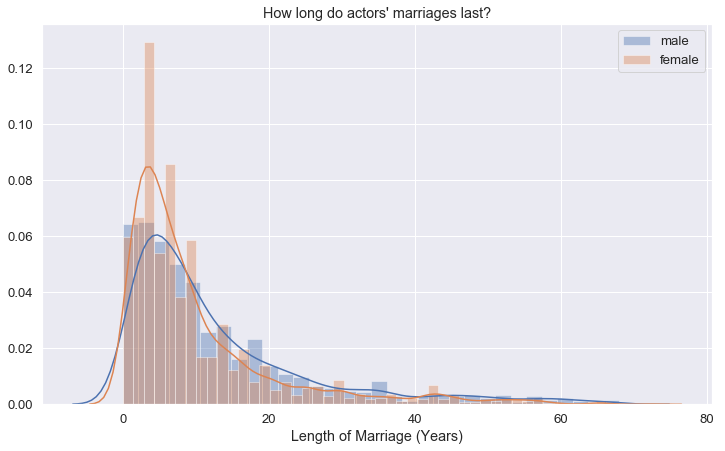

In [15]:
actor_marriages = nested_marriages.append(unnested_marriages)
actor_marriages['length']=actor_marriages['to']-actor_marriages['from']
sns.set(font_scale=1.2)
sns.distplot(a=actor_marriages['length'][(actor_marriages['gender']=='male') & (actor_marriages['length'].notnull())].astype(int), label="male", kde=True)
sns.distplot(a=actor_marriages['length'][(actor_marriages['gender']=='female') & (actor_marriages['length'].notnull())].astype(int), label="female", kde=True)
plt.gcf().set_size_inches(12, 7)
plt.xlabel('Length of Marriage (Years)')
plt.title('How long do actors\' marriages last?')
plt.legend()

In [16]:
still_married=actor_marriages[actor_marriages['reason'] =='still married'].name.count()/actor_marriages[actor_marriages['reason']!='unknown'].name.count() * 100
crude_divorce_rate=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/all_actors.name.count() * 100
divorce_to_marriage_ratio=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/actor_marriages.name.count() * 100
ended_marriages = actor_marriages[(actor_marriages['reason']=='divorce') | (actor_marriages['reason']=='death') | (actor_marriages['reason']=='annulment')].name.count()# | (actor_marriages['reason']=='unknown')
end_with_divorce=actor_marriages[actor_marriages['reason'] =='divorce'].name.count()/ended_marriages * 100
end_by_death=actor_marriages[actor_marriages['reason'] =='death'].name.count()/ended_marriages * 100
median_length=actor_marriages.length.median()
ten_year=actor_marriages[(actor_marriages['from']<=2009)&(actor_marriages['reason']=='still married')].name.count()/actor_marriages[actor_marriages['from']<=2009].name.count() * 100
twenty_year=actor_marriages[(actor_marriages['from']<=1999)&(actor_marriages['reason']=='still married')].name.count()/actor_marriages[actor_marriages['from']<=1999].name.count() * 100
print('Out of all actor marriages, %d%% of the couples are still married. The Crude Divorce Rate (number of divorces out of the population) of actors is %d%%, while the Divorce-to-Marriage '
      'Ratio (total number of divorces out of total number of marriages) is %d%%. \n\nAmong marriages that have ended with its cause included in Wikipedia, Divorce (%d%%) is the No.1 reason, followed by Death (%d%%). The median '
      'length of actors\' marriages is %d years - proving some truth to the "Seven-year Itch", although this is not considering marriages that are still ongoing. \n\nIf we look at all the couples that married at least a decade ago, %d%% of them have '
      'actually hit the ten-year mark. And %d%% couples who married at least twenty years ago are still together.' %(still_married, crude_divorce_rate,divorce_to_marriage_ratio, end_with_divorce, end_by_death,median_length, ten_year, twenty_year))

Out of all actor marriages, 64% of the couples are still married. The Crude Divorce Rate (number of divorces out of the population) of actors is 11%, while the Divorce-to-Marriage Ratio (total number of divorces out of total number of marriages) is 25%. 

Among marriages that have ended with its cause included in Wikipedia, Divorce (82%) is the No.1 reason, followed by Death (16%). The median length of actors' marriages is 7 years - proving some truth to the "Seven-year Itch", although this is not considering marriages that are still ongoing. 

If we look at all the couples that married at least a decade ago, 41% of them have actually hit the ten-year mark. And 31% couples who married at least twenty years ago are still together.


The distributions of both actors' and actresses' marriage lengths are positively skewed, showing that more marriages last shorter time. Again it is important to note that curent marriages might have existed a shorter time and/or have a potential to last longer compared to the ones that have ended. Therefore the above results may be biased as these current marriages are excluded due to their unpredictable nature.

The two distributions have similar spreads, but the peak of actresses' marriage lengths lies slightly to the left of that for their male counterparts. The values are also more centred around the peak while those for actors are more spread out, creating a fatter tail. This indicates that actresses' marriage lengths are more consistently shorter, while actors' marriage lengths tend to be longer and more varied.

Text(0.5, 1.0, 'Length of Marriage Across Generations (Excluding On-going Marriages)')

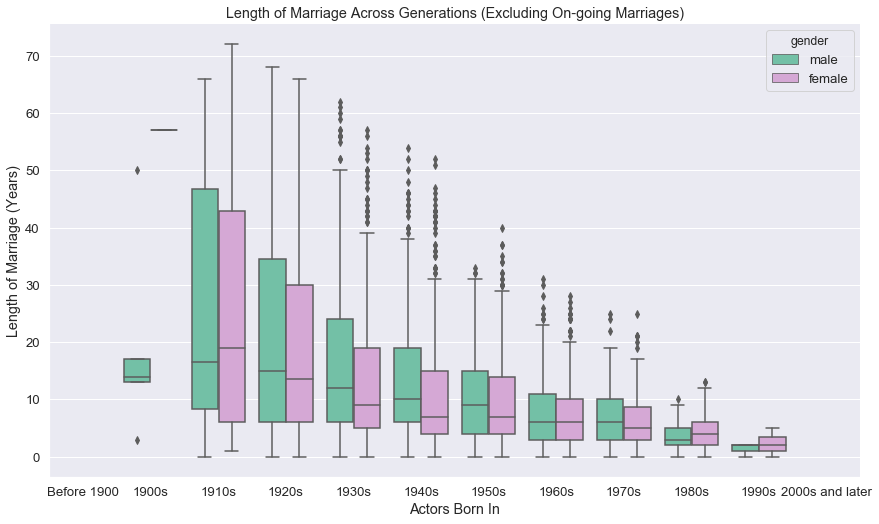

In [17]:
actor_marriages['age_group']=pd.cut(actor_marriages['birth_year'], bins=[1869, 1900, 1910, 1920, 1930, 1940, 1950,1960,1970,1980,1990,2000,2010], include_lowest=True, right=False, labels=['Before 1900','1900s', '1910s', '1920s','1930s','1940s','1950s','1960s','1970s','1980s','1990s','2000s and later'])
sns.set_style('ticks')
sns.set(font_scale=1.2)
sns.catplot(x='age_group', y='length', hue='gender', kind='box', data=actor_marriages, legend_out=False,palette=dict(male="mediumaquamarine", female="plum"))
plt.gcf().set_size_inches(16, 8)
plt.xlabel('Actors Born In')
plt.ylabel('Length of Marriage (Years)')
plt.title('Length of Marriage Across Generations (Excluding On-going Marriages)')

### When Do Actors Marry, When do They Encounter Their First Divorce, and How this Varies by Country

In [18]:
actor_marriages['age_married']=actor_marriages['from']-actor_marriages['birth_year']
actor_marriages['age_divorced']=actor_marriages['to']-actor_marriages['birth_year']
first_married=actor_marriages.groupby(['name','gender']).apply(lambda df: df.age_married.iloc[0]).dropna().reset_index() #age at first marriage
first_married.columns=['name','gender','first_married']
first_divorced=actor_marriages.groupby(['name','gender']).apply(lambda df: df.age_divorced.iloc[0]).dropna().reset_index() #age at first marriage
first_divorced.columns=['name','gender','first_divorced']
first_m_d = first_married.merge(first_divorced, on = ['name','gender'], how='outer')

In [19]:
first_m_d.describe()

,first_married,first_divorced
count,6487.000000,2825.000000
mean,30.903037,39.640354
std,7.952701,14.348735
min,14.000000,15.000000
25%,26.000000,30.000000
50%,30.000000,36.000000
75%,35.000000,45.000000
max,91.000000,99.000000


Text(0.5, 1.0, "Distribution of Actors' Age at First Marriage / First Divorce")

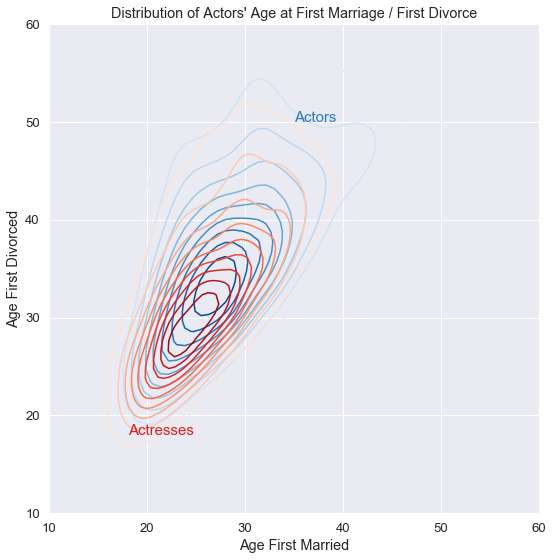

In [49]:
sns.set(style='darkgrid')
#plt.gcf().set_size_inches(10, 10)
sns.set(font_scale=1.2)
m_first_m_d = first_m_d[first_m_d['gender']=='male'].dropna()
f_first_m_d = first_m_d[first_m_d['gender']=='female'].dropna()
f, ax = plt.subplots(figsize=(9, 9))
ax.set_aspect('equal')
ax = sns.kdeplot(m_first_m_d['first_married'], m_first_m_d['first_divorced'], cmap='Blues', shade=False, shade_lowest=False)
ax = sns.kdeplot(f_first_m_d['first_married'], f_first_m_d['first_divorced'], cmap='Reds', shade=False, shade_lowest=False)
red = sns.color_palette('Reds')[-2]
blue = sns.color_palette('Blues')[-2]
ax.text(35, 50, "Actors", size=15, color=blue)
ax.text(18, 18, "Actresses", size=15, color=red)
plt.xlabel('Age First Married')
plt.ylabel('Age First Divorced')
plt.ylim(10, 60)
plt.xlim(10, 60)
plt.title('Distribution of Actors\' Age at First Marriage / First Divorce')

In [52]:
print('The median age when actors first get married is %d, while for actresses it is %d.'%(first_married[first_married['gender']=='male']['first_married'].median(), first_married[first_married['gender']=='female']['first_married'].median()))

The median age when actors first get married is 31, while for actresses it is 29.


Indian actor and professional wrestler Dara Singh got married the earliest among all actors and actresses - at the age of 14. A number of others were minors at the time they got married, but some had their marriages annulled within a few months' time. American singer and actress Aaliyah, at age 15, forged documents listing her as 18 and secretly married R. Kelly without her parents' knowledge. The illegal marriage was annulled six months later by her parents.

English actor and comedian Sir Ken Dodd was the oldest among all actors and actresses at the time of their first marriage. According to biographer Stephen Griffin, despite the "blossoming romance", the actor "thought that marriage could lead to complacency in a relationship, and caused some couples to stop putting in any effort". But he eventually married long-time partner Anne Jones at age 91, two days before his death.

Text(0.5, 1.0, 'Length of First Marriage in Relation to Age When Married (Excluding On-going Marriages)')

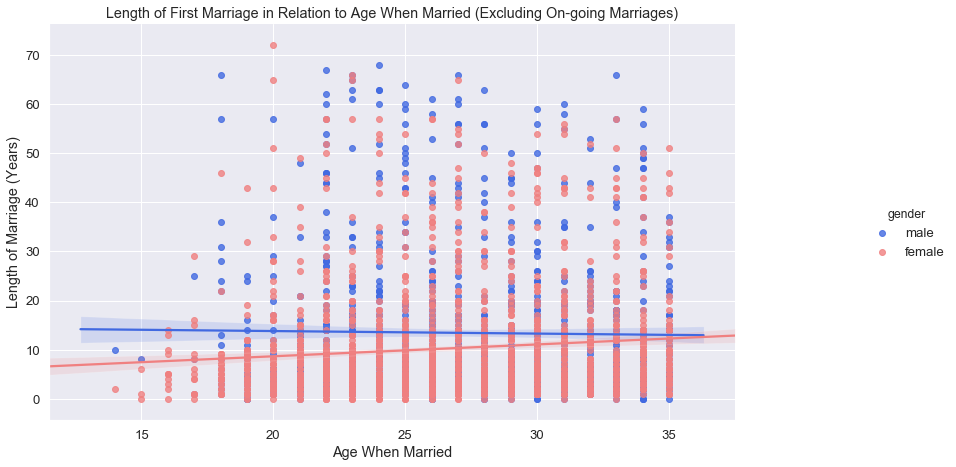

In [53]:
first_married2=actor_marriages.groupby(['name','gender','length']).apply(lambda df: df.age_married.iloc[0]).dropna().reset_index()
first_married2.columns=['name','gender','length','age_first_married']
sns.set_style('ticks')
sns.set(font_scale=1.2)
sns.lmplot(x="age_first_married", y="length", hue="gender", data=first_married2[first_married2['age_first_married']<=35], palette=dict(male="royalblue", female="lightcoral"))
plt.gcf().set_size_inches(15, 7)
plt.xlabel('Age When Married')
plt.ylabel('Length of Marriage (Years)')
plt.title('Length of First Marriage in Relation to Age When Married (Excluding On-going Marriages)')

According to neuroscientists, the frontal lobe of our brain, where we plan for the future and tackle questions that don't have black-and-white answers, does not reach full maturity until our late 20s or even into our 30s. Does this mean the later people marry, the more thought-through they were and the longer their marriages last? Looking at actors' first marriages which started when they were up to 35 (when 75% of actors who ever got married have entered their first marriage, exclusing non-first marriages where people might behave differently), it is interesting that actresses do display such tendency, while actors show the opposite trend.

In [81]:
first_married_nationality1 = first_married.merge(all_actors[['name','nationality']], on='name', how='inner')
first_married_nationality1.columns = ['name','gender','age_first_married','nationality']
first_married_nationality2 = first_married_nationality1.set_index(['name', 'gender', 'age_first_married'])['nationality'].apply(pd.Series).stack().to_frame()
first_married_nationality2=first_married_nationality2.reset_index()
first_married_nationality2.columns=['name','gender','age_first_married','level_3','nationality']
first_married_nationality2=first_married_nationality2.drop(['level_3'],axis=1)
first_married_nationality3=first_married_nationality2.groupby(['gender','nationality']).age_first_married.agg(['mean','count'])
first_married_nationality3=first_married_nationality3.reset_index()
first_married_nationality = first_married_nationality3[(first_married_nationality3['nationality'] != 'Unknown') & (first_married_nationality3['nationality'] != 'unknown')]
first_married_nationality.head()

,gender,nationality,mean,count
0,female,Albanian,29.000000,2
1,female,American,29.761621,1678
2,female,Argentine,29.250000,8
3,female,Armenian,22.000000,1
4,female,Australian,29.685714,70


In [82]:
first_married_nationality.describe()

,mean,count
count,158.000000,158.000000
mean,30.503639,40.746835
std,4.816557,184.758680
min,17.000000,1.000000
25%,27.500000,2.000000
50%,30.000000,5.000000
75%,32.970238,16.750000
max,52.500000,1678.000000


Text(100.5, 0.5, 'Nationality')

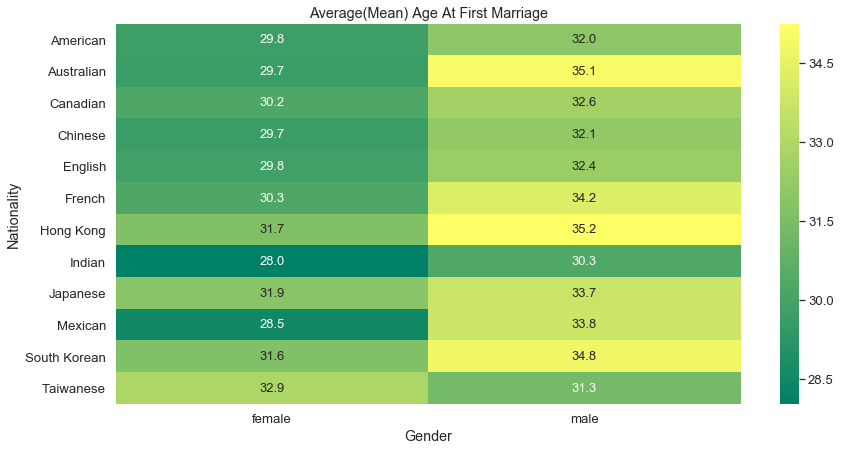

In [86]:
first_married_heatmap=first_married_nationality[first_married_nationality['nationality'].isin(['American', 'English', 'Indian',
                        'Canadian', 'Hong Kong', 'Chinese', 'Mexican', 'Australian', 'South Korean', 'French',
                        'Japanese','Taiwanese'])].sort_values(by='count', ascending=False).pivot(index='nationality',columns='gender',values='mean')
plt.figure(figsize=(14,7))
plt.title("Average(Mean) Age At First Marriage")
ax = sns.heatmap(data=first_married_heatmap, annot=True, fmt='.1f', annot_kws={"size":13},cmap='summer') #cmap=sns.cm.rocket_r
ax.set_yticklabels(ax.get_yticklabels(),rotation=0)
plt.xlabel("Gender")
plt.ylabel("Nationality")

### Below is still in progress

#### Do Actors Marry Other Actors?

#### How Does Actors' Divorce Rate Compare to Politicians and Sports Stars?

#### Other Interesting Observations

In [491]:
marriage_by_nationality = actor_marriages.set_index(['name', 'age_married', 'age_divorced'])['nationality'].apply(pd.Series).stack()
marriage_by_nationality = actor_marriages.reset_index()
marriage_by_nationality.nationality=marriage_by_nationality.nationality.apply(lambda x: x[0] if len(x)>0 else np.nan)
first_married=marriage_by_nationality.groupby(['name','nationality','gender']).apply(lambda df: df.age_married.iloc[0]).dropna().reset_index()

#first_married.columns = ['name','nationality','gender','aged_first_married']
#nationality=marriage_by_nationality.groupby(['name','nationality','gender']).apply(lambda df: df.age_divorced.iloc[0]).dropna().reset_index()
#first_divorced.columns = ['name','nationality','gender','aged_first_divorced']

In [433]:
actor_marriages[(actor_marriages['age_married']<18) | (actor_marriages['age_divorced']<18)]

,name,label,gender,nationality,awards_count,spouse_count,spouse,from,to,birth_year,reason,length,age_group,age_married,age_divorced
1,Aaliyah,nested,female,[American],0,1,R. Kelly,1994.0,1995.0,1979.0,annulment,1.0,1970s,15.0,16.0
257,Silvia Pinal,nested,female,[Mexican],3,4,Rafael Banquells,1947.0,1952.0,1931.0,divorce,5.0,1930s,16.0,21.0
279,Dimple Kapadia,nested,female,[Indian],2,1,Rajesh Khanna,1973.0,1982.0,1957.0,None,9.0,1950s,16.0,25.0
448,Michael Learned,nested,female,[American],1,4,Peter Donat,1956.0,1972.0,1939.0,divorce,16.0,1930s,17.0,33.0
626,Glória Pires,nested,female,[Brazilian],0,2,Fábio Júnior,1979.0,1983.0,1963.0,divorce,4.0,1960s,16.0,20.0
752,Peggy Stewart (actress),nested,female,[American],0,2,"Don "" Red "" Barry",1940.0,1944.0,1923.0,unknown,4.0,1920s,17.0,21.0
864,Sowcar Janaki,nested,female,[Indian],2,1,Sankaramanchi Srinivasa Rao,1947.0,NaN,1931.0,still married,NaN,1930s,16.0,NaN
990,Dara Singh,nested,male,[Indian],0,2,Bachno Kau,1942.0,1952.0,1928.0,unknown,10.0,1920s,14.0,24.0
1035,Laila Morse,nested,female,[English],0,1,Gerald Bromfield,1962.0,1970.0,1945.0,divorce,8.0,1940s,17.0,25.0
1229,Kristina Orbakaitė,nested,male,[],0,3,Vladimir Presnyakov Jr.,1988.0,1996.0,1971.0,divorce,8.0,1970s,17.0,25.0


In [592]:
combined_actors[combined_actors['age']==999][50:]

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,label,gender,nationality,awards,awards_count,spouse,spouse_count,age
15392,Sheelu Abraham,unknown,NaN,NaN,NaN,nested,female,[Indian],[],0,[{'spouse': 'Abraham'}],1,999
15396,Arsher Ali,unknown,NaN,NaN,NaN,nested,male,[English],[],0,"[{'spouse': 'Roxy Shahidi', 'from': '2010', 't...",1,999
15422,Celia Kwok,NaN,,,,nested,female,[Hong Kong],[award= ],1,"[{'spouse': '', 'from': ''}]",1,999
15471,Suchendra Prasad,unknown,NaN,NaN,NaN,nested,male,[Indian],[],0,"[{'spouse': 'Pavitra Lokesh', 'from': '2007'}]",1,999
15494,David Adkins (actor),unknown,NaN,NaN,NaN,nested,male,[American],[],0,"[{'spouse': 'Laura Linney', 'from': '1995', 't...",1,999
15527,Shivani Tanksale,unknown,NaN,NaN,NaN,nested,female,[Indian],[],0,"[{'spouse': 'Sumeet Vyas', 'from': '2010', 'to...",1,999
15567,Lizz Njagah,NaN,YYYY,MM,DD,nested,female,[Kenyan],[],0,"[{'spouse': 'Alexandros Konstantaras', 'from':...",1,999
15694,Shuko Akune,unknown,NaN,NaN,NaN,nested,female,[American],[],0,"[{'spouse': 'Michael W. Pacelli', 'from': '199...",1,999
15782,Morgan Spector,unknown,NaN,NaN,NaN,nested,male,[American],[],0,"[{'spouse': 'Rebecca Hall', 'from': '2015'}]",1,999
15802,Harikrishnan,unknown,NaN,NaN,NaN,nested,male,[Indian],[],0,"[{'spouse': 'Divya', 'from': '2016'}]",1,999


In [243]:
# check specific record
all_actors[all_actors['name']=='John Cleese']

,name,birth_day,birth_day.year,birth_day.month,birth_day.date,spouse,label,gender,nationality,awards,awards_count
43,John Cleese,NaN,1939,10,27,"[{'spouse': 'Connie Booth', 'from': '1968', 't...",nested,male,[English],"[Category:BAFTA winners (people), Category:Bes...",3
